In [114]:
import numpy as np
import matplotlib.pyplot as plt
import pandas as pd
import seaborn as sns

In [115]:
import os
os.environ["CUDA_VISIBLE_DEVICES"] = "1"
os.environ["TF_CPP_MIN_LOG_LEVEL"] = "1"

In [116]:
import tensorflow as tf

In [117]:
import tensorflow.keras.backend as K

In [118]:
from tensorflow.keras.applications import EfficientNetB0
from tensorflow.keras.applications.efficientnet import preprocess_input
import matplotlib.pyplot as plt

In [119]:
# gpus = tf.config.experimental.list_physical_devices('GPU')
# if gpus:
#   try:
#     tf.config.experimental.set_virtual_device_configuration(gpus[0], [tf.config.experimental.VirtualDeviceConfiguration(memory_limit=1024*6)])
#   except RuntimeError as e:
#     print(e)

In [120]:
df = pd.read_csv('edge_images/preprocessed.csv')

In [121]:
df.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 53416 entries, 0 to 53415
Data columns (total 11 columns):
 #   Column        Non-Null Count  Dtype  
---  ------        --------------  -----  
 0   ID            53416 non-null  object 
 1   Sex           53416 non-null  object 
 2   Height        53416 non-null  object 
 3   Weight        53416 non-null  object 
 4   Hair          53416 non-null  object 
 5   Eyes          53416 non-null  object 
 6   Race          53416 non-null  object 
 7   Sex Offender  53416 non-null  bool   
 8   Offense       53416 non-null  object 
 9   Height_cm     53416 non-null  float64
 10  Weight_kg     53416 non-null  float64
dtypes: bool(1), float64(2), object(8)
memory usage: 4.1+ MB


In [126]:
import os

img_filenames = os.listdir('edge_images/front/front')

img_filenames = pd.Series(img_filenames).apply(lambda x : str(x).split('.')[0])

In [127]:
np.any(~df['ID'].isin(img_filenames))

False

In [128]:
data = df[['ID', 'Weight_kg']]

In [129]:
data['ID'] = 'edge_images/front/front/'+data['ID']+'.jpg'

/tmp/ipykernel_699907/939288133.py:1: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  data['ID'] = 'edge_images/front/front/'+data['ID']+'.jpg'


In [130]:
data['ID']

0        edge_images/front/front/A00147.jpg
1        edge_images/front/front/A00198.jpg
2        edge_images/front/front/A01072.jpg
3        edge_images/front/front/A01077.jpg
4        edge_images/front/front/A01148.jpg
                        ...                
53411    edge_images/front/front/Y29993.jpg
53412    edge_images/front/front/Y29994.jpg
53413    edge_images/front/front/Y29996.jpg
53414    edge_images/front/front/Y30000.jpg
53415    edge_images/front/front/Y54605.jpg
Name: ID, Length: 53416, dtype: object

In [131]:
train_data = data[:int(0.8*len(data))]
val_data = data[int(0.8*len(data)):int(0.9*len(data))]
test_data = data[int(0.9*len(data)):]

# convert to tuple
train_data = (train_data['ID'].values, train_data['Weight_kg'].values)
val_data = (val_data['ID'].values, val_data['Weight_kg'].values)
test_data = (test_data['ID'].values, test_data['Weight_kg'].values)

In [132]:
BATCH_SIZE = 64

In [135]:
# read images file by file path
def read_imgs(file_paths):
    imgs = tf.TensorArray(tf.float32, size=BATCH_SIZE)
    i=0
    for file_path in file_paths:
        img = tf.io.read_file(file_path)
        img = tf.image.decode_jpeg(img, channels=3)
        img = tf.image.resize(img, (224, 224))
        img = preprocess_input(img)
        imgs = imgs.write(i, img)
        i+=1
    return imgs.stack()

In [136]:
train_data[0][:5]

array(['edge_images/front/front/A00147.jpg',
       'edge_images/front/front/A00198.jpg',
       'edge_images/front/front/A01072.jpg',
       'edge_images/front/front/A01077.jpg',
       'edge_images/front/front/A01148.jpg'], dtype=object)

In [137]:
read_imgs(train_data[0][:5])

<tf.Tensor: shape=(64, 224, 224, 3), dtype=float32, numpy=
array([[[[0.00000000e+00, 0.00000000e+00, 0.00000000e+00],
         [0.00000000e+00, 0.00000000e+00, 0.00000000e+00],
         [0.00000000e+00, 0.00000000e+00, 0.00000000e+00],
         ...,
         [0.00000000e+00, 0.00000000e+00, 0.00000000e+00],
         [0.00000000e+00, 0.00000000e+00, 0.00000000e+00],
         [0.00000000e+00, 0.00000000e+00, 0.00000000e+00]],

        [[0.00000000e+00, 0.00000000e+00, 0.00000000e+00],
         [0.00000000e+00, 0.00000000e+00, 0.00000000e+00],
         [0.00000000e+00, 0.00000000e+00, 0.00000000e+00],
         ...,
         [0.00000000e+00, 0.00000000e+00, 0.00000000e+00],
         [0.00000000e+00, 0.00000000e+00, 0.00000000e+00],
         [0.00000000e+00, 0.00000000e+00, 0.00000000e+00]],

        [[0.00000000e+00, 0.00000000e+00, 0.00000000e+00],
         [0.00000000e+00, 0.00000000e+00, 0.00000000e+00],
         [0.00000000e+00, 0.00000000e+00, 0.00000000e+00],
         ...,
         [

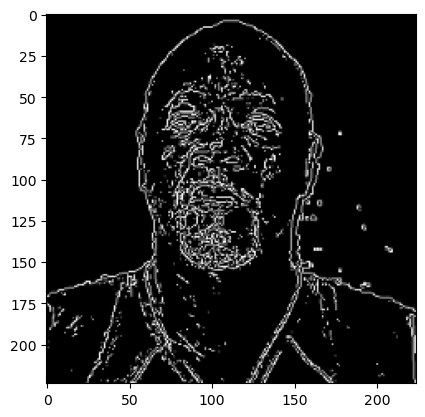

In [141]:
plt.imshow(tf.cast(read_imgs(train_data[0][:5])[3], tf.int32))

In [105]:
# run eagerly
# tf.config.run_functions_eagerly(True)
train_set = tf.data.Dataset.from_tensor_slices(train_data).shuffle(10000).batch(BATCH_SIZE, drop_remainder=True).map(lambda x, y: (read_imgs(x), y)).prefetch(1)
val_set = tf.data.Dataset.from_tensor_slices(val_data).shuffle(10000).batch(BATCH_SIZE, drop_remainder=True).map(lambda x, y: (read_imgs(x), y)).prefetch(1)
test_set = tf.data.Dataset.from_tensor_slices(test_data).shuffle(10000).batch(BATCH_SIZE, drop_remainder=True).map(lambda x, y: (read_imgs(x), y)).prefetch(1)

In [107]:
# Data augmentation layers
data_augmentation_front = tf.keras.Sequential([
    tf.keras.layers.RandomFlip("horizontal"),
    tf.keras.layers.RandomBrightness(factor = (-0.15, 0.1)),  # adjust according to your needs
    tf.keras.layers.RandomZoom(height_factor=(-0.1, 0.05)),        # adjust according to your needs
])
data_augmentation_side = tf.keras.Sequential([
    tf.keras.layers.RandomBrightness(factor = (-0.25, 0.1)),  # adjust according to your needs
    tf.keras.layers.RandomContrast(0.5),    # adjust according to your needs
    tf.keras.layers.RandomZoom(height_factor=(-0.2, 0.1)),        # adjust according to your needs
])

In [108]:
# create model
base_model = EfficientNetB0(include_top=False, weights='imagenet', input_shape=(224, 224, 3))

model = tf.keras.Sequential([
    data_augmentation_front, 
    base_model,
    tf.keras.layers.GlobalAveragePooling2D(),
    tf.keras.layers.Dense(1)
])

In [82]:
for i, layer in enumerate(base_model.layers[:20]):
    print(i, layer.name)

0 input_1
1 rescaling
2 normalization
3 rescaling_1
4 stem_conv_pad
5 stem_conv
6 stem_bn
7 stem_activation
8 block1a_dwconv
9 block1a_bn
10 block1a_activation
11 block1a_se_squeeze
12 block1a_se_reshape
13 block1a_se_reduce
14 block1a_se_expand
15 block1a_se_excite
16 block1a_project_conv
17 block1a_project_bn
18 block2a_expand_conv
19 block2a_expand_bn


In [93]:
for layer in base_model.layers[:16]:
    layer.trainable = False

model.build(input_shape=(None, 224,224,3))
model.compile(optimizer='adam', loss='mean_squared_error', metrics=['mae'])
K.set_value(model.optimizer.learning_rate, 0.01*model.optimizer.learning_rate)
model.summary()

Model: "sequential_1"
_________________________________________________________________
 Layer (type)                Output Shape              Param #   
 efficientnetb0 (Functional)  (None, 7, 7, 1280)       4049571   
                                                                 
 global_average_pooling2d_1   (None, 1280)             0         
 (GlobalAveragePooling2D)                                        
                                                                 
 dense_1 (Dense)             (None, 1)                 1281      
                                                                 
Total params: 4,050,852
Trainable params: 4,006,997
Non-trainable params: 43,855
_________________________________________________________________


In [94]:
early_stopping = tf.keras.callbacks.EarlyStopping(patience=5, restore_best_weights=True)

In [95]:
model.fit(train_set, validation_data=val_set, epochs=100, callbacks = [early_stopping])

Epoch 1/100
667/667 [==============================] - 181s 262ms/step - loss: 6453.8164 - mae: 78.3514 - val_loss: 4671.0005 - val_mae: 66.2663
Epoch 2/100
667/667 [==============================] - 176s 264ms/step - loss: 5049.4043 - mae: 69.1052 - val_loss: 4231.9512 - val_mae: 62.9667
Epoch 3/100
667/667 [==============================] - 175s 262ms/step - loss: 4480.3711 - mae: 64.9423 - val_loss: 3677.8096 - val_mae: 58.4518
Epoch 4/100
667/667 [==============================] - 176s 263ms/step - loss: 4022.4812 - mae: 61.3709 - val_loss: 3374.8196 - val_mae: 55.8297
Epoch 5/100
667/667 [==============================] - 174s 261ms/step - loss: 3619.1296 - mae: 58.0486 - val_loss: 2960.3628 - val_mae: 52.0500
Epoch 6/100
667/667 [==============================] - 176s 263ms/step - loss: 3253.3276 - mae: 54.8654 - val_loss: 2668.0962 - val_mae: 49.2268
Epoch 7/100
667/667 [==============================] - 175s 262ms/step - loss: 2917.3965 - mae: 51.7635 - val_loss: 2383.9758 - va

In [96]:
model.save_weights('models/frontweight_edge_img1')

In [110]:
tf.get_logger().setLevel('ERROR')

In [111]:
model.load_weights('models/frontweight_edge_img2')

base_model.trainable = True

model.build(input_shape=(None, 224,224,3))
model.compile(optimizer='adam', loss='mean_squared_error', metrics=['mae'])
K.set_value(model.optimizer.learning_rate, 0.01*model.optimizer.learning_rate)
model.summary()
model.fit(train_set, validation_data=val_set, epochs=100, callbacks = [early_stopping])


Model: "sequential_6"
_________________________________________________________________
 Layer (type)                Output Shape              Param #   
 sequential_4 (Sequential)   (None, 224, 224, 3)       0         
                                                                 
 efficientnetb0 (Functional)  (None, 7, 7, 1280)       4049571   
                                                                 
 global_average_pooling2d_2   (None, 1280)             0         
 (GlobalAveragePooling2D)                                        
                                                                 
 dense_2 (Dense)             (None, 1)                 1281      
                                                                 
Total params: 4,050,852
Trainable params: 4,008,829
Non-trainable params: 42,023
_________________________________________________________________
Epoch 1/100
667/667 [==============================] - 433s 636ms/step - loss: 190.7378 - mae: 10.6011 - 

In [112]:
model.save_weights('models/frontweight_edge_img3.h5')

In [113]:
model.evaluate(test_set)

83/83 [==============================] - 6s 74ms/step - loss: 215.0188 - mae: 10.9637


[215.0187530517578, 10.963668823242188]